<a href="https://colab.research.google.com/github/mcpechka/tunabundel/blob/master/Energy_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Energy Mismatch

## Intermittent nature of renewables

The intermittent and stochastic nature of renewable energy sources, such as solar, results in a mismatch between solar energy yield and solar energy demand. The seasonal surplus and deficit are particularly large and become apparent when one examines yearly **energy demand** and **energy generation** patterns.

_Learning objectives:_
- Understand the nature of energy mismatch(why does it occur)
- Understand the indicators that characterize the energy mismatch and be able to calculate them
- Understand the relevance of these indicators and the importnace of tackling the energy mismatch


In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import datetime as dt
import numpy as np
from scipy import integrate

In this notebook we will analyze the case of a house with 20 m2 of rooftop PV panels. The demand profile represents the average electricity demand of a dwelling in Eindhoven.

In [ ]:
#Let us upload the mismatch.csv file with representations of an on-site energy
#generation profile [kWh] and an energy demand profile [kWh].

uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving mismatch (1).csv to mismatch (1).csv


In [ ]:
#Further, we put the data into a Pandas dataframe for convenience.
df = pd.read_csv(filename)
df['Date'] = pd.to_datetime(pd.date_range('2019-01-01','2019-12-31 23:00:00',freq='H'))
df = df.set_index('Date')
df

,Demand,Supply
Date,,
2019-01-01 00:00:00,0.396084,0.0
2019-01-01 01:00:00,0.332123,0.0
2019-01-01 02:00:00,0.270083,0.0
2019-01-01 03:00:00,0.221211,0.0
2019-01-01 04:00:00,0.208089,0.0
...,...,...
2019-12-31 19:00:00,0.613007,0.0
2019-12-31 20:00:00,0.581118,0.0
2019-12-31 21:00:00,0.515447,0.0


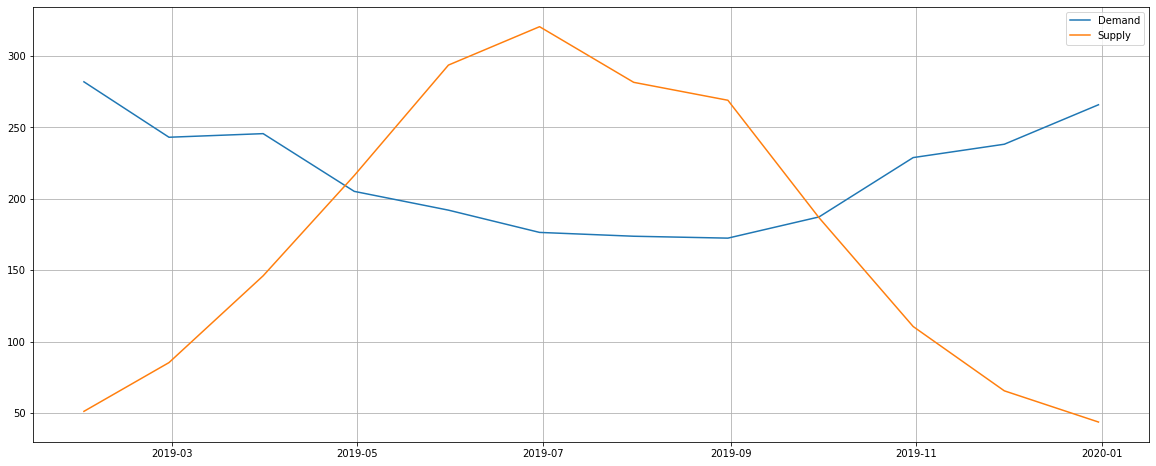

In [ ]:
#The plot below illustrates the annual on-site energy production
#and annual energy demand at a monthly resolution, for the simulated case.
df_monthly = df.resample('M').sum()

plt.rcParams['figure.figsize'] = 20, 8
plt.plot(df_monthly.index, df_monthly['Demand'], df_monthly.index, df_monthly['Supply'])
plt.legend(['Demand', 'Supply'])
plt.grid()
plt.show()

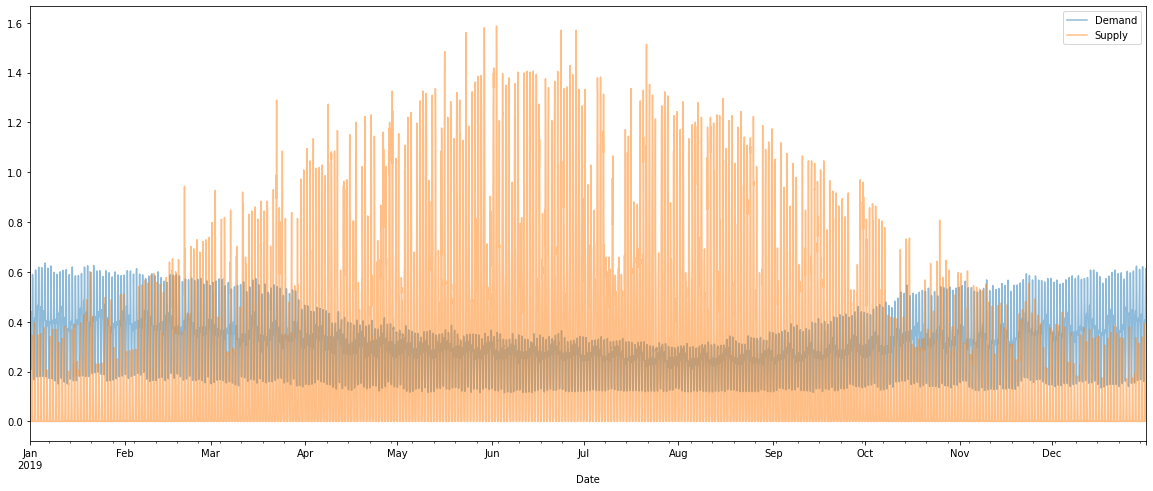

In [ ]:
#Most of mismatch between the demand and the supply generated by the photovoltaic
#panels, however, occurs throughout the day.
df.plot(alpha = 0.5)

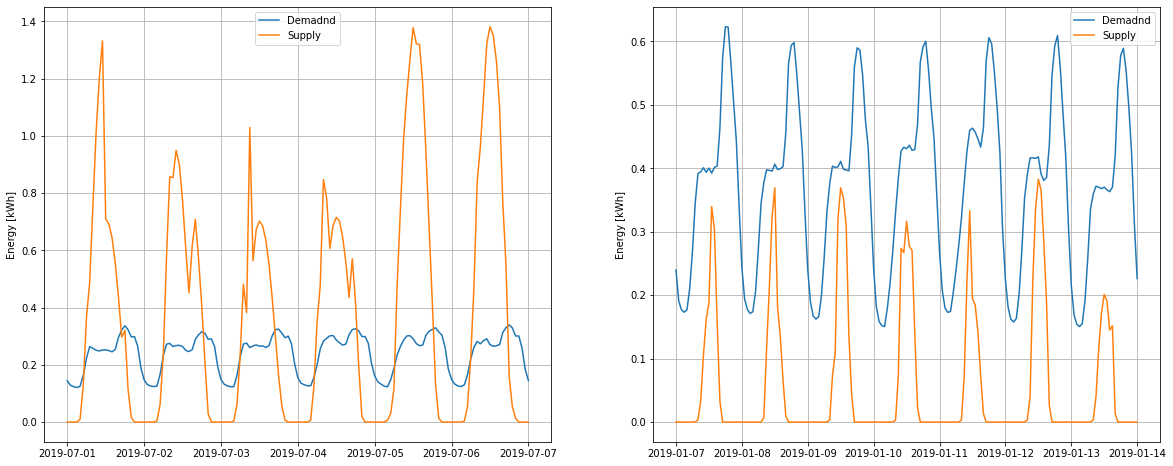

In [ ]:
#It is hard to observe anything form the plot above because the data is too dense.
#Therefore, let's zoom into a typical summer week and a typical winter week and see what is happening there.

summer_week = df.truncate(before = '2019-07-01', after = '2019-07-07')
winter_week = df.truncate(before = '2019-01-07', after = '2019-01-14')

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(summer_week)
ax2.plot(winter_week)
for ax in (ax1, ax2):
  ax.grid()
  ax.legend(['Demadnd', 'Supply'])
  ax.set_ylabel('Energy [kWh]')

# Energy Matching

There exist two prominent factors which describe the matching of the on-site energy system. Firstly, one may refer to the **On-site Energy Matching (OEM) factor**, which can be calculated as follows:

$OEM = \frac{\int_{t_1}^{t_2} Min[g(t);d(t)]\mathrm{d}t}{\int_{t_1}^{t_2} g(t)\mathrm{d}t}$ , where $g(t)$ is the energy generated on-site and $d(t)$ is the energy demand.

Secondly, one may calculate the **On-site Energy Fraction (OEF)** as follows:

$OEF = \frac{\int_{t_1}^{t_2} Min[g(t);d(t)]\mathrm{d}t}{\int_{t_1}^{t_2} d(t)\mathrm{d}t}$ , where $g(t)$ is the energy generated on-site and $d(t)$ is the energy demand.

![OEM_OEF.PNG](https://ars.els-cdn.com/content/image/1-s2.0-S0378778813003150-gr2.jpg)

Source: https://doi.org/10.1016/j.enbuild.2013.05.030

We can calculate the total energy consumed on-site via 3 steps.

1. Identify the minimum values at every discrete step:

In [ ]:
data = pd.DataFrame()
data['Demand'] = df['Demand']
data['Supply'] = df['Supply']
data['Energy matching'] = data[['Supply', 'Demand']].min(axis = 1)

df_days = pd.pivot_table(data, index=df.index.hour, columns=df.index.date, aggfunc='sum')

def plot(date):
  plt.scatter(np.arange(1, 25, 1) ,df_days[('Demand', pd.to_datetime(date).date())], alpha = 0.7, s = 100)
  plt.scatter(np.arange(1, 25, 1) ,df_days[('Supply', pd.to_datetime(date).date())], alpha = 0.7, s = 100)
  plt.plot(np.arange(1, 25, 1) ,df_days[('Energy matching', pd.to_datetime(date).date())], c = 'red')
  plt.ylabel('Energy [kWh]')
  plt.xlabel('Hour')
  plt.show()

widgets.interact(plot, date=widgets.DatePicker(value=pd.to_datetime('2019-05-01')))


interactive(children=(DatePicker(value=Timestamp('2019-05-01 00:00:00'), description='date'), Output()), _dom_…

<function __main__.plot>

2. Interpolate the array
3. Integrate the function

In [ ]:
#Here both steps 2 and 3 are done in the same step.
#A linear interpolation is applied to the data to obtain a continuous function, as
#an integration cannot be applied to discrete data. Then the function is integrated.
def onsite_energy(df):
  df['Energy matching'] = df[['Supply', 'Demand']].min(axis = 1)
  em_array = np.array(df['Energy matching'])
  index_array = np.array(df.index)

  emint = pd.Series(em_array, index_array)

  totuse = integrate.trapz(emint.values)
  return totuse

print(f"The total energy used on-site amounts to {onsite_energy(data)} kWh.")

The total energy used on-site amounts to 1043.519534622 kWh.


In [ ]:
#In order to calculate the on-site energy matching
#factor and on-site energy fraction, you also need the total energy supply
#and total energy demand:
def energy_mismatch(df):
  index_array = np.array(df.index)
  gen_array = np.array(df['Supply'])
  genint = pd.Series(gen_array, index_array)

  totgen = integrate.trapz(genint.values)

  dem_array = np.array(df['Demand'])
  demint = pd.Series(dem_array, index_array)

  totdem = integrate.trapz(demint.values)
  #This leads to the final step:

  OEM = onsite_energy(df)/totgen
  OEF = onsite_energy(df)/totdem

  return {'OEM': OEM, 'OEF': OEF}

print(f"The on-site energy matching factor(OEM) amounts to {energy_mismatch(data)['OEM']}.")
print(f"The on-site energy fraction(OEF) amounts to {energy_mismatch(data)['OEF']}.")

The on-site energy matching factor(OEM) amounts to 0.5041814932348688.
The on-site energy fraction(OEF) amounts to 0.3999016555979687.


## *Assignment*

In this assignment you have to analyze the energy mismatch during one summer week and one winter week. See in the able below which weeks you have too analyze.

|First letter surname student| Summer week        |   | Second letter surname student| Winter week        |
|----------------------------|--------------------|---|----------------------------|--------------------|
|A - B                       |02/06 - 08/06       |   |A - B                       |01/01 - 07/01       |
|C - D                       |09/06 - 15/06       |   |C - D                       |08/01 - 14/01       |
|E - F                       |16/06 - 22/06       |   |E - F                       |15/01 - 21/01       |
|G - H                       |23/06 - 29/06       |   |G - H                       |22/01 - 28/01       |
|I - J                       |30/06 - 06/07       |   |I - J                       |29/01 - 04/02       |
|K - L                       |07/07 - 13/07       |   |K - L                       |05/02 - 11/02       |
|M - N                       |14/07 - 20/07       |   |M - N                       |12/02 - 18/02       |
|O - P                       |21/07 - 27/07       |   |O - P                       |19/02 - 25/02       |
|Q - R                       |28/07 - 03/08       |   |Q - R                       |24/11 - 30/11       |
|S - T                       |04/08 - 10/08       |   |S - T                       |01/12 - 07/12       |
|U - V                       |11/08 - 17/08       |   |U - V                       |08/12 - 14/12       |
|W - X                       |18/08 - 24/08       |   |W - X                       |15/12 - 21/12       |
|Y - Z                       |25/08 - 31/08       |   |Y - Z                       |22/12 - 28/12       |


In [ ]:
#use the 'truncate' function to keep only the data you are intersted in
summer_week = df.truncate(...)
winter_week =

SyntaxError: ignored

Plot the deamnd and supply during those weeks.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(summer_week)
ax2.plot(winter_week)
for ax in (ax1, ax2):
  ax.grid()
  ax.legend(['Demadnd', 'Supply'])
  ax.set_ylabel('Energy [kWh]')

Caluclate the OEM and OEF during those weeks.

In [ ]:
#the function energy mismatch takes as input a dataset that contains demand and
#supply profiles and returns OEM and OEF
print(f'Summer week mismatch: {energy_mismatch(summer_week)}')
print(f'Winter week mismatch: {energy_mismatch(winter_week)}')


##Questions

- **What are the values of OEM and OEF during the analyzed weeks, with 20 m2 of rooftop PV panels?**

Now try to double or/and half the amount of rooftop surface covered with PV panels.
- **How does the change in the amount of the installed PV panels influence these metrics?**


In [ ]:
#run this cell to change the rooftop area
#and then run the cells from the assignment section again

rooftop_area = 40 # square meters

df['Supply'] = data['Supply']/20*rooftop_area

Please note that it is also possible to use this Notebook as a starting point for post-processing the data from simulation assignment 6+7